# Домашнее задание №2 - Линейные модели. Градиентный спуск

Импортируем необходимые модули:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd
import math

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import load_boston
from sklearn.preprocessing import (StandardScaler, LabelEncoder, OneHotEncoder)
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score, mean_squared_error, roc_auc_score, roc_curve, 
                            accuracy_score, plot_confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    return np.sum(np.sin(w)**2)

# проверяю себя
# x = np.array([1.57, 1.57])
# f(x)

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуем функцию, которая будет осуществлять градиентный спуск для функции $f$:

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    return 2 * np.sin(w) * np.cos(w)

# проверяю себя
# x = np.array([1, 2])
# grad_f(x)

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
        curr_w -= lr * grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.gca(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

Звездочки спустились к "минимуму", однако ранее до графика функция также возвращала много текста (вероятно, элементы списка), а затем появилось предупреждение.

/tmp/ipykernel_15490/1727858522.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


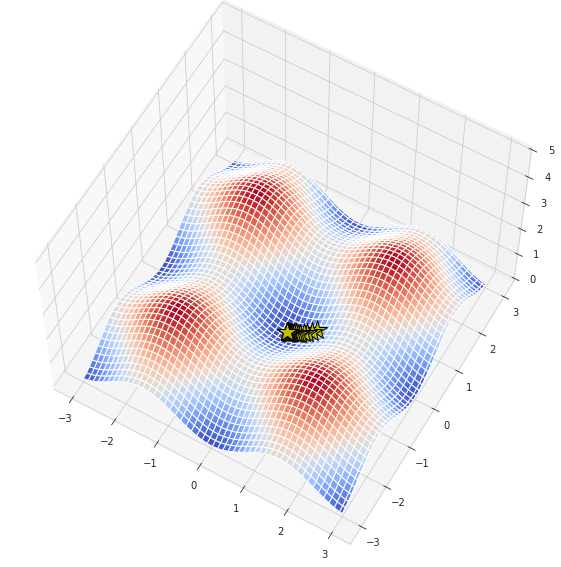

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

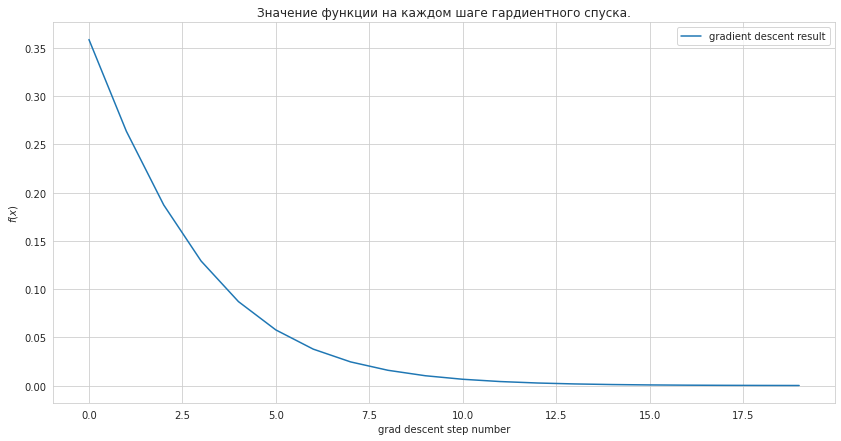

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

Допишем функцию для MSE и ее градиента:

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    s = 0
    for el in range(len(y_true)):
        s += (y_true[el] - y_pred[el])**2
    msee = 1 / len(y_true) * s
    return msee


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
    mse_g = 2 / len(y_true) * np.matmul(X.transpose(), (y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
    return mse_g


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)
    
# проверяю себя
# X = np.array([[1, 2, 3, 4], [1, 0, 2, 4], [0, 3, 2, 1]])
# y_true = np.array([10, 11, 12])
# y_pred = np.array([11, 11, 13])

# aaa = MSELoss()
# aaa.calculate_gradient(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

Реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий:

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуем метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
       
        y_pred = np.matmul(X_test, self.W)
        
        return y_pred        
    
    
    def __repr__(self):
        return "My custom linear regression"

Думаю, что я ошиблась в расчетах, поскольку информацию про свободный член я так и не использовала, только перемножила Xi на wi и суммировала для получения y_pred

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

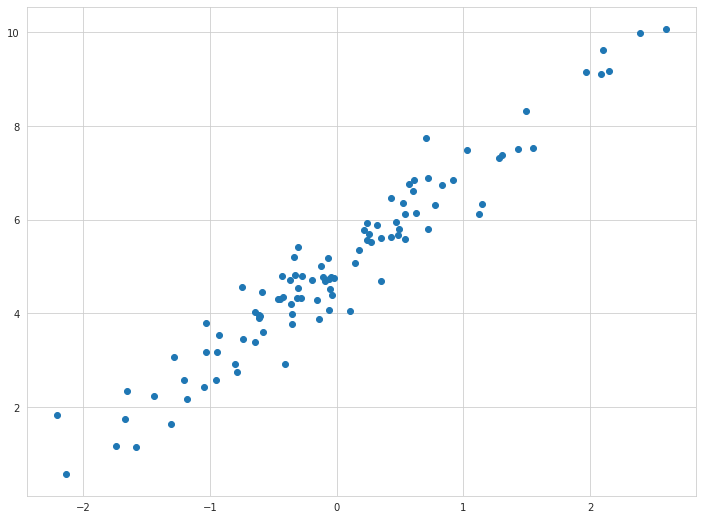

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

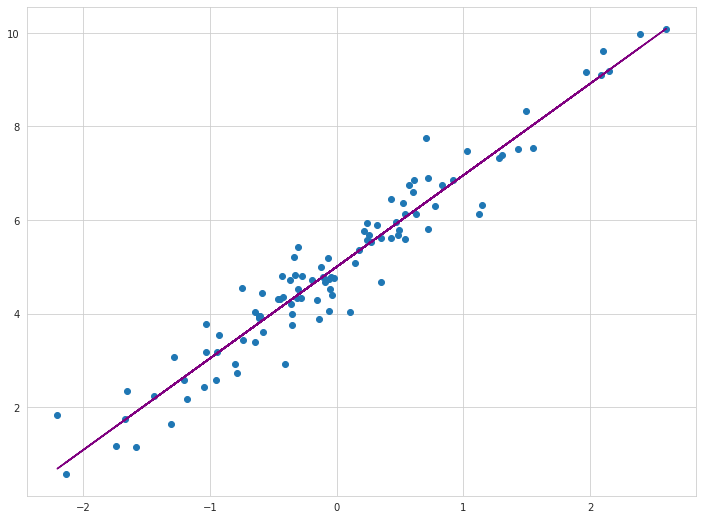

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X), color = "purple");

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Бостоне. Построим модель линейной регресии при помощи `LinearRegression` из `sklearn`. Разделим данные на тренировочную и тестовую части и предобработаем признаки. Воспользуемся изученными метриками регресии и сделаем выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = load_boston()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

# import pandas as pd
# import numpy as np

# data_url = "http://lib.stat.cmu.edu/datasets/boston"
# raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
# X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
# y = raw_df.values[1::2, 2]

/home/maria/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing datas

In [20]:
feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

Для удобства, переведем наши данные в формат pandas dataframe и series:

In [21]:
X_df = pd.DataFrame(data = X)
X_df.columns = feature_names
X_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [22]:
y_ser = pd.Series(y)
y_ser

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Length: 506, dtype: float64

В нашей таблице - данные о стоимости 506 домов, а также информация о 13 параметрах (о 14, если считать таргетную переменную)
Посмотрим, какие параметры есть у описанных в датасете домов:

CRIM - per capita crime rate by town\
ZN - proportion of residential land zoned for lots over 25,000 sq.ft.\
INDUS - proportion of non-retail business acres per town.\
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)\
NOX - nitric oxides concentration (parts per 10 million)\
RM - average number of rooms per dwelling\
AGE - proportion of owner-occupied units built prior to 1940\
DIS - weighted distances to five Boston employment centres\
RAD - index of accessibility to radial highways\
TAX - full-value property-tax rate per \\$10,000\
PTRATIO - pupil-teacher ratio by town\
B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town\
LSTAT - \% lower status of the population\
MEDV - Median value of owner-occupied homes in \\$1000's

Категориальные данные уже переведены в формат нулей и единиц (CHAS)

In [23]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


In [24]:
X_df.std()

CRIM         8.601545
ZN          23.322453
INDUS        6.860353
CHAS         0.253994
NOX          0.115878
RM           0.702617
AGE         28.148861
DIS          2.105710
RAD          8.707259
TAX        168.537116
PTRATIO      2.164946
B           91.294864
LSTAT        7.141062
dtype: float64

Можем заметить, что в таблице отсутствуют пропущенные значения, однако достаточно большой разброс стандартных отклонений. Нормализуем наши данные, предварительно разбив их на тестовую и тренировочную выборки.

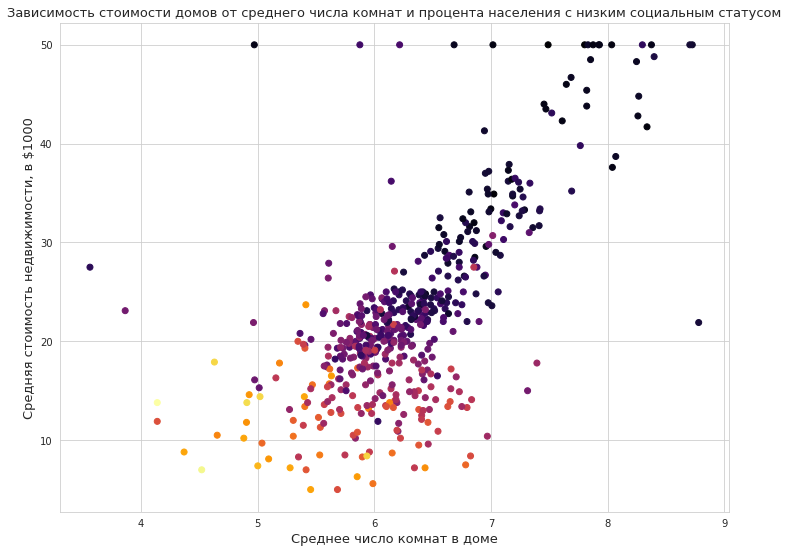

In [25]:
plt.scatter(x = X_df["RM"], y = y_ser, c = X_df["LSTAT"], cmap = "inferno", linewidth = 1)
plt.title("Зависимость стоимости домов от среднего числа комнат и процента населения с низким социальным статусом", fontsize=13)
plt.xlabel("Среднее число комнат в доме", fontsize=13)
plt.ylabel("Средняя стоимость недвижимости, в $1000", fontsize=13)
plt.show()

Разобьем наши данные на тренировочные и тестовые выборки:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_ser, test_size=0.2, random_state=SEED)

In [27]:
num_cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']

Воспользуемся пайплайном для предобработки результатов и обучения модели:

In [28]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols)])
reg_pipeline = Pipeline(steps=[("preprecessor", preprocessor), ("lr", LinearRegression())])
reg_pipeline.fit(X_train, y_train)
y_pred = reg_pipeline.predict(X_test)
print("R2:", round(r2_score(y_test, y_pred), 3))
print("MSE", round(mean_squared_error(y_test, y_pred), 3))

R2: 0.746
MSE 23.066


Не уверена, можно ли воспользоваться циклом, чтобы оценить R2 для каждого из параметров модели, выбрать с наибольшими значениями R2, а остальные параметры убрать? Если правильно понимаю, для LinearRegression() и LogisticRegression() есть возможность вернуть коэффициенты модели или какое-то summary, и уже по ним судить о вкладе каждого признака в предсказание стоимости дома. Но я не знаю, как это сделать для пайплайна.

In [29]:
R2 = []
MSE = []
for i in range(len(num_cols)):
    preprocessor = ColumnTransformer(transformers=[("scaler", StandardScaler(), [num_cols[i]])])
    reg_pipeline = Pipeline(steps=[("preprecessor", preprocessor), ("lr", LinearRegression())])
    reg_pipeline.fit(X_train, y_train)
    y_pred = reg_pipeline.predict(X_test)
    print(f'Parameter: {num_cols[i]}')
    r2 = round(r2_score(y_test, y_pred), 3)
    R2.append(r2)
    print(f'R2 score: {r2}')
    mse = round(mean_squared_error(y_test, y_pred), 3)
    MSE.append(mse)
    print(f'MSE: {mse}')
    print()

Parameter: CRIM
R2 score: 0.069
MSE: 84.463

Parameter: ZN
R2 score: 0.139
MSE: 78.066

Parameter: INDUS
R2 score: 0.231
MSE: 69.706

Parameter: CHAS
R2 score: 0.009
MSE: 89.833

Parameter: NOX
R2 score: 0.165
MSE: 75.703

Parameter: RM
R2 score: 0.488
MSE: 46.437

Parameter: AGE
R2 score: 0.086
MSE: 82.903

Parameter: DIS
R2 score: 0.041
MSE: 86.957

Parameter: RAD
R2 score: 0.141
MSE: 77.924

Parameter: TAX
R2 score: 0.224
MSE: 70.416

Parameter: PTRATIO
R2 score: 0.239
MSE: 69.062

Parameter: B
R2 score: 0.071
MSE: 84.258

Parameter: LSTAT
R2 score: 0.487
MSE: 46.562



Немного изменю значения MSE, чтобы удобнее было сравнить их с изменениями R2, поместив на одном графике. Можно предположить, что параметры RM и LSTAT наиболее важны для модели, чуть менее, но также важны INDUS, TAX и PTRATIO, ZN, NOX и RAD. Вероятно, CRIM, CHAS, AGE, DIS и B в наименьшей степени влияют на предсказание моделью стоимости недвижимости.

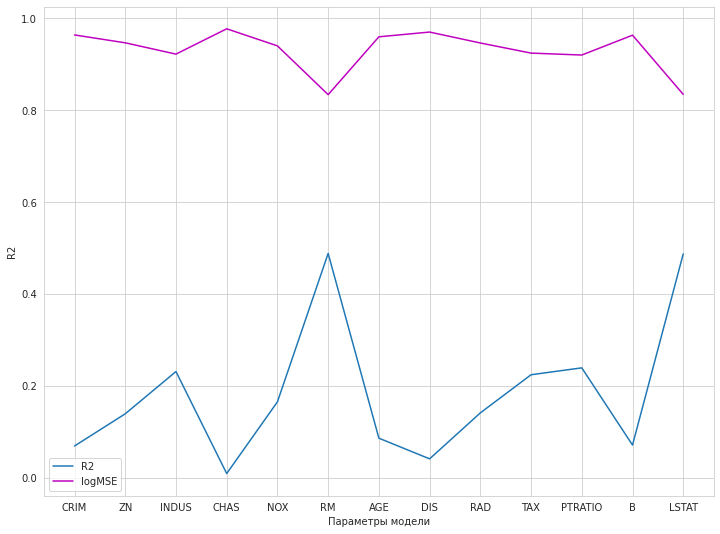

In [30]:
logMSE = []
for el in range(len(MSE)):
    logMSE.append(math.log(MSE[el], 100))
plt.plot(num_cols, R2, label="R2")
plt.plot(num_cols, logMSE, label="logMSE", color = "m")
plt.legend()
plt.xlabel("Параметры модели")
plt.ylabel("R2")
plt.show()

Уберем из списка параметров CRIM, CHAS, AGE, DIS и B:

In [31]:
new_num_cols = ['ZN', 'INDUS', 'NOX', 'RM', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']
X_train, X_test, y_train, y_test = train_test_split(X_df, y_ser, test_size=0.2, random_state=SEED)
preprocessor = ColumnTransformer(transformers=[("scaler", StandardScaler(), new_num_cols)])
reg_pipeline = Pipeline(steps=[("preprecessor", preprocessor), ("lr", LinearRegression())])
reg_pipeline.fit(X_train, y_train)
y_pred = reg_pipeline.predict(X_test)
print("R2:", round(r2_score(y_test, y_pred), 3))
print("MSE", round(mean_squared_error(y_test, y_pred), 3))

R2: 0.687
MSE 28.369


Последующее добавление параметров CRIM, CHAS, AGE, DIS и B изменияет значения R2 и MSE, но незначительно.

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуем функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [32]:
import math

def sigmoid(y_pred):
    # output результат X@w (-inf, +inf)
    new_y_pred = []
    for el in y_pred:
        new_y_pred.append(1 / (math.exp(-el) + 1))
    return np.array(new_y_pred)

# # проверяю себя
# sigmoid(np.array([-1, 100]))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

Допишем формулы для функций bce и bce_grad:

In [33]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    bc_en = 0
    for el in range(len(y_true)):
        bc_en -= (y_true[el] * math.log(y_pred[el]) + (1 - y_true[el])*math.log(1 - y_pred[el]))
    bc_en = bc_en / len(y_true)
    return bc_en
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    print(y_pred)
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")    
    bce_g = np.matmul(X.transpose(), y_pred.reshape(-1,1) - y_true.reshape(-1,1))
    return bce_g


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

In [34]:
# проверяю себя: bce, bce_grad
# X = np.array([[1, 2, 3, 4], [1, 0, 2, 4], [10,  15, 16, 13]])
# y_true = np.array([1, 1, 0])
# y_pred = np.array([100, 100, -1])
# y_pred = sigmoid(y_pred)
# a = BCELoss()
# print(a.__call__(y_true, y_pred))
# b = a.calculate_gradient(y_true, y_pred, X)
# print(b)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуем метод `predict` у класса `CustomLogisticRegression` (свободный член!)

In [35]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = np.matmul(X_test, self.W)
        new_pred = sigmoid(y_pred)
        return new_pred
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [46]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

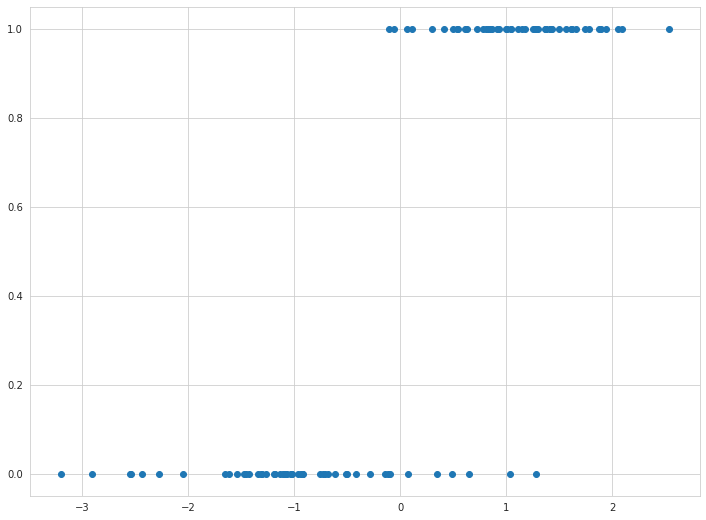

In [47]:
plt.scatter(X, y);

In [48]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

[0.6065052  0.61586984 0.62079497 0.68664465 0.64258172 0.64800404
 0.6204411  0.61654138 0.68851187 0.61029486 0.62762001 0.62785179
 0.69853323 0.63541809 0.67930224 0.59581842 0.61053907 0.69544649
 0.68874125 0.59710058 0.69441881 0.67552534 0.60051802 0.62034645
 0.6423648  0.68907002 0.68388355 0.71990779 0.68706099 0.71421637
 0.67821099 0.58211813 0.68416091 0.62122423 0.61184538 0.68703143
 0.62371702 0.74323597 0.63093652 0.69125189 0.61795996 0.67246773
 0.63457755 0.70269803 0.60534271 0.61991624 0.69107763 0.63148364
 0.63353887 0.63393346 0.69897508 0.6609695  0.61403125 0.66129895
 0.69334446 0.64617323 0.6370339  0.70064919 0.67853239 0.66606122
 0.73598041 0.63970939 0.64951325 0.64353368 0.67719676 0.65625558
 0.67237948 0.62744373 0.72706243 0.62441812 0.69764038 0.62866057
 0.61660171 0.68524157 0.67000138 0.72673175 0.72420362 0.69469467
 0.62881666 0.60193946 0.60261547 0.65977077 0.61768238 0.60907565
 0.6621862  0.68988746 0.66093919 0.68426623 0.65594576 0.6840

 9.48133443e-01 7.75530569e-01 7.62579603e-01 1.76805048e-02]
[9.77174920e-01 9.54672143e-01 9.35341500e-01 7.06849097e-02
 7.28266614e-01 6.36319452e-01 9.36958453e-01 9.52408281e-01
 6.10724936e-02 9.69836363e-01 8.95487158e-01 8.93804454e-01
 2.70825710e-02 8.24167689e-01 1.22841016e-01 9.89637397e-01
 9.69290898e-01 3.49478542e-02 5.99775902e-02 9.88606469e-01
 3.80131073e-02 1.60476289e-01 9.85330300e-01 9.37384429e-01
 7.31617516e-01 5.84395373e-02 8.74019451e-02 4.28783273e-03
 6.84301214e-02 7.08464148e-03 1.32882002e-01 9.96233687e-01
 8.55769537e-02 9.33327437e-01 9.66204815e-01 6.85880110e-02
 9.20416893e-01 5.06735267e-04 8.69001619e-01 4.91159980e-02
 9.47262677e-01 1.97149635e-01 8.33428112e-01 1.90993512e-02
 9.79049874e-01 9.39286359e-01 4.98068820e-02 8.64110007e-01
 8.44315977e-01 8.40251201e-01 2.61046095e-02 3.83976300e-01
 9.60350224e-01 3.77734857e-01 4.14860509e-02 6.69014817e-01
 8.05209163e-01 2.26953903e-02 1.29856478e-01 2.92511214e-01
 9.97911327e-04 7.70398

[9.84714411e-01 9.66411654e-01 9.49432863e-01 4.60607697e-02
 7.34360022e-01 6.30025049e-01 9.50888448e-01 9.64474553e-01
 3.88500278e-02 9.78960853e-01 9.11931882e-01 9.10288992e-01
 1.51749467e-02 8.39165834e-01 8.81020182e-02 9.93800767e-01
 9.78523872e-01 2.03546422e-02 3.80411986e-02 9.93092113e-01
 2.24285806e-02 1.20943433e-01 9.90780813e-01 9.51270919e-01
 7.38110903e-01 3.69095093e-02 5.90338150e-02 1.84501832e-03
 4.43521200e-02 3.27015252e-03 9.66798173e-02 9.98043609e-01
 5.75925749e-02 9.47611592e-01 9.76029536e-01 4.44714311e-02
 9.35734020e-01 1.62559412e-04 8.85612055e-01 3.01671919e-02
 9.60018007e-01 1.54608002e-01 8.48926697e-01 1.01615236e-02
 9.86143067e-01 9.52973474e-01 3.06595742e-02 8.80651302e-01
 8.60297923e-01 8.56066472e-01 1.45465162e-02 3.45141935e-01
 9.71201888e-01 3.38376132e-01 2.48124294e-02 6.67366511e-01
 8.18948718e-01 1.23857760e-02 9.40804176e-02 2.48445276e-01
 3.51230272e-04 7.81118883e-01 5.97933424e-01 7.17487320e-01
 1.05297750e-01 4.472843

 9.69439078e-01 7.96010809e-01 7.80710714e-01 5.21574619e-03]
[9.89261110e-01 9.74215945e-01 9.59297846e-01 3.12660129e-02
 7.39190942e-01 6.23875383e-01 9.60604404e-01 9.72552869e-01
 2.58304980e-02 9.84683230e-01 9.24276498e-01 9.22691628e-01
 9.04603794e-03 8.51203148e-01 6.49760125e-02 9.96054003e-01
 9.84329002e-01 1.25449386e-02 2.52286691e-02 9.95551078e-01
 1.39780578e-02 9.31564256e-02 9.93873182e-01 9.60946934e-01
 7.43287172e-01 2.43894232e-02 4.13304869e-02 8.74448141e-04
 2.99670124e-02 1.64785578e-03 7.21999738e-02 9.98899638e-01
 4.01957923e-02 9.57656526e-01 9.82291339e-01 3.00575034e-02
 9.46787870e-01 5.95390691e-05 8.98477681e-01 1.94616009e-02
 9.68685933e-01 1.23359596e-01 8.61294133e-01 5.79254732e-03
 9.90369892e-01 9.62467658e-01 1.98170602e-02 8.93525768e-01
 8.72951947e-01 8.68626695e-01 8.63028166e-03 3.12019582e-01
 9.78278112e-01 3.04926003e-01 1.56454308e-02 6.65373238e-01
 8.30078736e-01 7.21731937e-03 7.00000460e-02 2.13081935e-01
 1.39571056e-04 7.89861

 9.73463362e-01 8.01004782e-01 7.85135648e-01 3.75658449e-03]
[9.91215651e-01 9.77823273e-01 9.64037859e-01 2.50070783e-02
 7.41795781e-01 6.20212789e-01 9.65259814e-01 9.76306586e-01
 2.04215400e-02 9.87215866e-01 9.30531543e-01 9.28987117e-01
 6.72730084e-03 8.57638894e-01 5.44408472e-02 9.96947663e-01
 9.86903118e-01 9.50554228e-03 1.99174574e-02 9.96535700e-01
 1.06578463e-02 7.99856586e-02 9.95143551e-01 9.65579749e-01
 7.46085246e-01 1.92158143e-02 3.36336860e-02 5.71290907e-04
 2.39060728e-02 1.11461735e-03 6.09205521e-02 9.99206537e-01
 3.26532050e-02 9.62499350e-01 9.85096198e-01 2.39826705e-02
 9.52222487e-01 3.35989989e-05 9.05158256e-01 1.51287870e-02
 9.72758794e-01 1.08058128e-01 8.67873686e-01 4.20074947e-03
 9.92170879e-01 9.66998030e-01 1.54215896e-02 9.00236822e-01
 8.79640240e-01 8.75282169e-01 6.40098478e-03 2.93843299e-01
 9.81502184e-01 2.86620657e-01 1.20075309e-02 6.64098651e-01
 8.36080157e-01 5.29912621e-03 5.89418734e-02 1.94568986e-01
 8.25003463e-05 7.94619

 9.75546938e-01 8.03837862e-01 7.87651761e-01 3.10694358e-03]
[9.92179453e-01 9.79676881e-01 9.66528238e-01 2.19636650e-02
 7.43281358e-01 6.18074634e-01 9.67701815e-01 9.78241232e-01
 1.78174935e-02 9.88485501e-01 9.33921366e-01 9.32402412e-01
 5.66701392e-03 8.61243956e-01 4.91049500e-02 9.97368750e-01
 9.88194930e-01 8.09388762e-03 1.73635703e-02 9.97002155e-01
 9.10767487e-03 7.31663046e-02 9.95754128e-01 9.68008855e-01
 7.47681197e-01 1.67324081e-02 2.98344932e-02 4.46638924e-04
 2.09655100e-02 8.89054979e-04 5.51716279e-02 9.99343157e-01
 2.89358055e-02 9.65048714e-01 9.86511918e-01 2.10349006e-02
 9.55116032e-01 2.41372405e-05 9.08832223e-01 1.30725892e-02
 9.74871363e-01 9.99897965e-02 8.71547324e-01 3.48785487e-03
 9.93054520e-01 9.69368790e-01 1.33337666e-02 9.03936268e-01
 8.83359055e-01 8.78988666e-01 5.38385405e-03 2.83612119e-01
 9.83145323e-01 2.76333414e-01 1.02996679e-02 6.63346673e-01
 8.39461770e-01 4.43123924e-03 5.33161899e-02 1.84428893e-01
 6.08768757e-05 7.97322

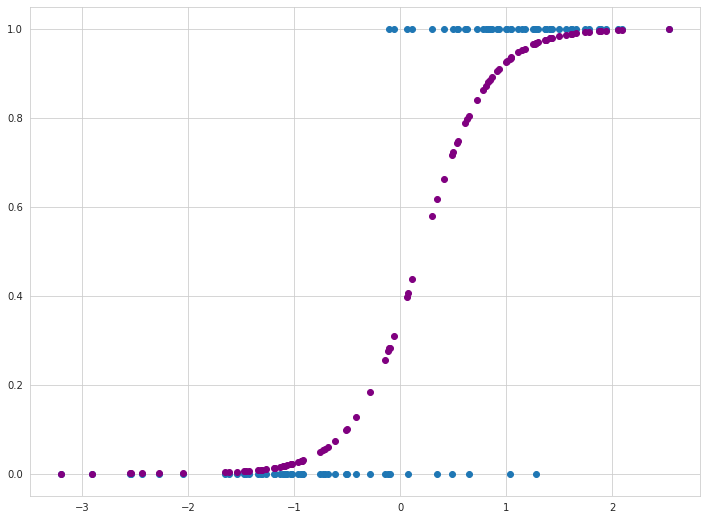

In [49]:
plt.scatter(X, y)
plt.scatter(X, y_pred, color = "purple");

Проверим качество работы модели при помощи постоения ROC кривой и вычисления площади под ней.\
Создадим массив, в котором первый столбец будет содержать значения y_true, второй - y_pred, третий-восьмой - количество верных предсказаний при определенной заданной границе (от 0 до 1 с шагом 0,2):

In [50]:
thresholds = [0, 0.2, 0.4, 0.6, 0.8, 1]
roc = np.zeros((len(y), 8))
roc[:, 0] = y
roc[:, 1] = y_pred

for i in range(len(thresholds)):
    for j in range(len(y)):
        if roc[j,1] >= thresholds[i]:
            roc[j,i + 2] = 1

Подсчитаем True Positive Rate (TPR) и False Positive Rate (FPR):

In [51]:
TPR = []
FPR = []
for i in range(len(thresholds)):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for j in range(len(y)):
        if roc[j,0] == roc[j, i + 2]:
            if roc[j,0] == 1:
                TP += 1
            else:
                TN += 1
        else:
            if roc[j,0] == 1:
                FN += 1
            else:
                FP += 1
    TPR.append(TP / (TP + FN))
    FPR.append(FP / (FP + TN))
print(TPR)
print(FPR)

[1.0, 1.0, 0.94, 0.9, 0.78, 0.0]
[1.0, 0.18, 0.12, 0.1, 0.06, 0.0]


Изобразим на графике зависимость FPR от TPR:

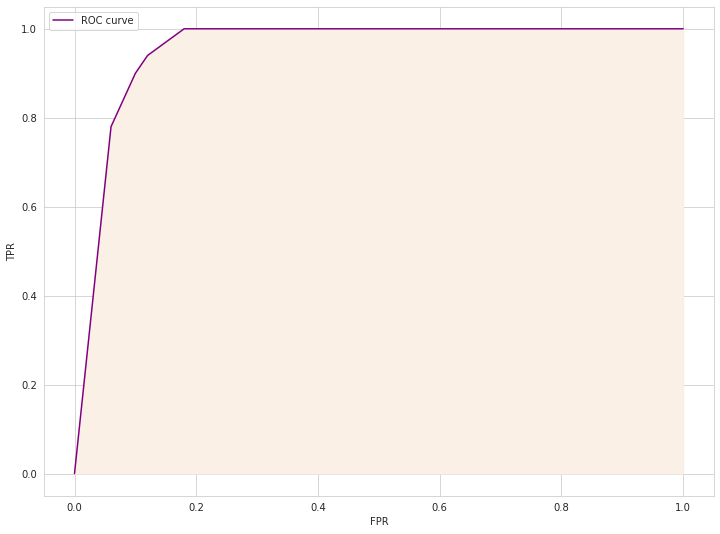

In [52]:
plt.plot(FPR, TPR, label="ROC curve", color = "purple")
plt.fill_between(FPR, TPR, np.zeros_like(TPR), color='linen')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Поскольку вывести формулу для расчета площади под ROC кривой для меня сейчас немного нетривиальное задание (хотя просто нужно посчитать площади треугольников и прямоугольников и вычесть из 1, но я пока не могу это облечь в нормальную формулу), я воспользовалась формулой расчета метрик из sklearn. Когда пересчитывала самостоятельно, AUC равнялось 0,972 (но значения всегда несколько отличаются)

In [53]:
auc = roc_auc_score(y, y_pred)
print("Показатель AUC равен", round(auc, 3))

Показатель AUC равен 0.97


#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon).
Посмотрим на наши данные:

In [54]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Для некоторых наблюдений в столбце "Name" - странные названия (например, "VenusaurMega Venusaur"). Это можно исправить, но это не влияет на предсказание.

In [55]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


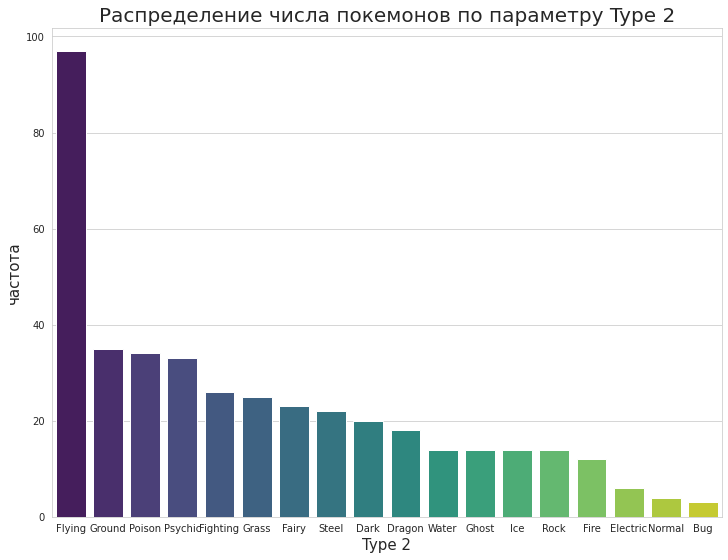

In [56]:
sns.countplot(x = pokemon["Type 2"], palette="viridis", order = pokemon["Type 2"].value_counts().index)
plt.title("Распределение числа покемонов по параметру Type 2", fontsize = 20)
plt.xlabel("Type 2", fontsize = 15)
plt.ylabel("частота", fontsize = 15)
plt.show()

Можно заметить, что в столбце "Type 2" есть пропущенные значения. Просторы интернета говорят, что в таких случаях можно или удалить строки, содержащие данные пропуски (но тогда у нас останется лишь половина нашего датасета), или заполнить их. В случае заполнения - если данные количественные, можем посчитать среднее или медиану по столбцу и заполнить пропуски этими значениями, если же данные категориальные, то можно превратить NaN также в категорию, или заменить (значениями для "Type 1"). Ну или, как вариант, удалить данный столбец из наших данных. 

In [57]:
pokemon["Type 2"].fillna(pokemon["Type 1"], inplace=True)

Посмотрим на наш датасет. Пропуски во 2 столбце заменены на соотвествующие значения из 1 столбца.

In [58]:
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,Fire,309,39,52,43,60,50,65,1,False


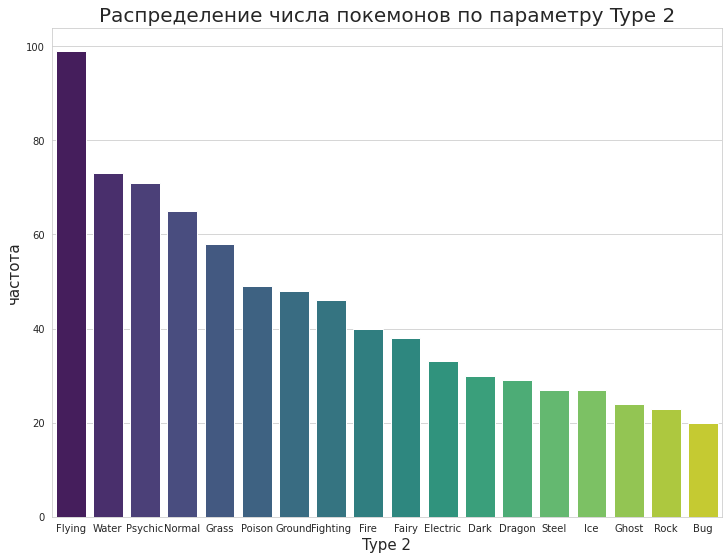

In [59]:
sns.countplot(x = pokemon["Type 2"], palette="viridis", order = pokemon["Type 2"].value_counts().index)
plt.title("Распределение числа покемонов по параметру Type 2", fontsize = 20)
plt.xlabel("Type 2", fontsize = 15)
plt.ylabel("частота", fontsize = 15)
plt.show()

Распределение по "Type 2" всё-таки несколько изменилось. Попробуем посчитать с этим параметром, а потом - без него.

Заменим значение целевой переменной на "0" и "1":

In [60]:
le = LabelEncoder()
pokemon["Legendary"] = le.fit_transform(pokemon['Legendary'])
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,0
4,4,Charmander,Fire,Fire,309,39,52,43,60,50,65,1,0


Можем воспользоваться пайплайном для преобработки наших данных (разделим признаки на категориальные и количественные):

In [61]:
pokemon.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

In [62]:
cat_cols = ['Type 1', 'Type 2', 'Generation']
num_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
all_features = cat_cols + num_cols

In [63]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(), cat_cols)
])

In [64]:
X = pokemon[all_features]
y = pokemon['Legendary'].values

Разделим данные на тренировочные и тестовык выборки и обучим модель с помощью LogisticRegression из sklearn:

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=SEED)
y_test

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [66]:
logit_reg_pipeline = Pipeline(steps=[
    ("preprecessor", preprocessor),
    ("lr", LogisticRegression())
])
logit_reg_pipeline.fit(X_train, y_train)
y_pred = logit_reg_pipeline.predict(X_test)

Нарисуем confusion matrix:

In [67]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[74,  0],
       [ 5,  1]])

Я не совладала с plot_confusion_matrix, поэтому искала, как можно нарисовать по-другому:

Text(0.5, 574.24, 'Predicted label')

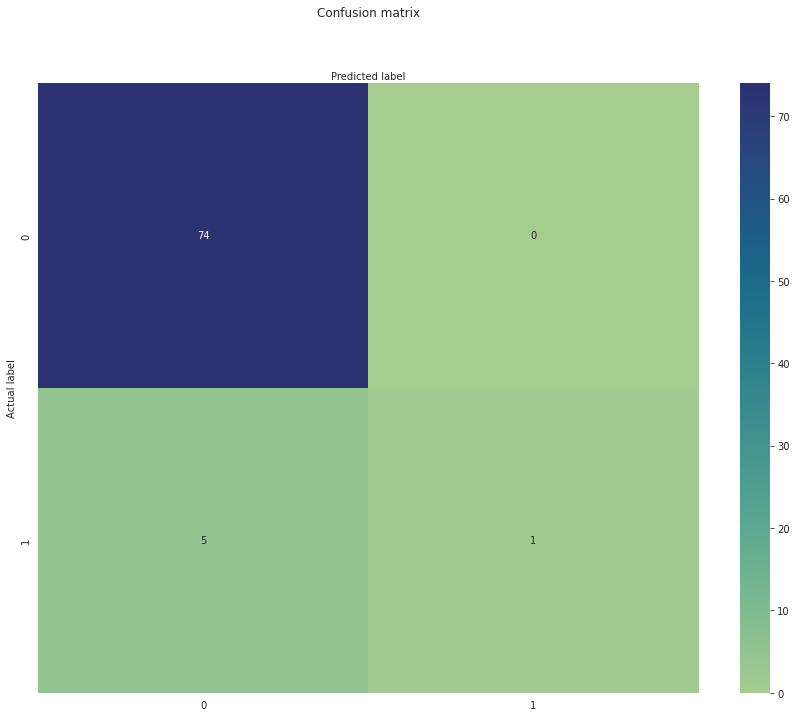

In [68]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="crest" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Рассчитаем AUC с помощью roc_auc_score:

In [69]:
auc = roc_auc_score(y_test, y_pred)
print("Показатель AUC равен", round(auc, 3))

Показатель AUC равен 0.583


Метрики модели:

In [70]:
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 3))
print("Precision:", round(metrics.precision_score(y_test, y_pred), 3))
print("Recall:", round(metrics.recall_score(y_test, y_pred), 3))

Accuracy: 0.938
Precision: 1.0
Recall: 0.167


Тут я совсем запуталась, я думала, модель будет возвращать вероятности от 0 до 1, но она возвращает уже категорию. Поэтому я затрудняюсь нарисовать в данном случае ROC-кривую вручную.
Воспользуемся уже готовым инструментом:

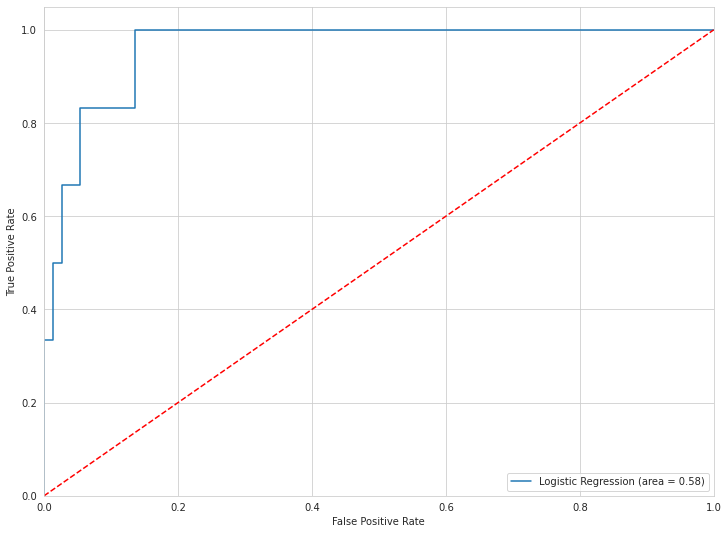

In [71]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logit_reg_pipeline.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Вернемся к нашим первичным данным и пересчитаем без параметра "Type 2"

In [72]:
cat_cols = ['Type 1', 'Generation']
num_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
all_features = cat_cols + num_cols

preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(), cat_cols)
])

X = pokemon[all_features]
y = pokemon['Legendary'].values

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=SEED)
y_test

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [74]:
logit_reg_pipeline = Pipeline(steps=[
    ("preprecessor", preprocessor),
    ("lr", LogisticRegression())
])
logit_reg_pipeline.fit(X_train, y_train)
y_pred = logit_reg_pipeline.predict(X_test)

In [75]:
auc = roc_auc_score(y_test, y_pred)
print("Показатель AUC равен", round(auc, 3))

Показатель AUC равен 0.57


In [76]:
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 3))
print("Precision:", round(metrics.precision_score(y_test, y_pred), 3))
print("Recall:", round(metrics.recall_score(y_test, y_pred), 3))

Accuracy: 0.912
Precision: 0.333
Recall: 0.167


Показатели AUC, accuracy, precision и recall несколько ухудшились при удалении из модели параметра "Type 2"

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Pink Floyd. Это всё семейное, от папы. Слушала их с пеленок :)

Из композиций любимые:
+ [High Hopes](https://music.youtube.com/watch?v=9qqOB1YtfRA&feature=share)
+ [Hey You](https://music.youtube.com/watch?v=soL8JK6kALc&feature=share)
+ [Wish You Were Here](https://music.youtube.com/watch?v=hjpF8ukSrvk&feature=share)

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Да, было интересно, и чуть легче, чем в первый раз) Очень помогают комментарии в тексте формул и классов (особенно, в каком формате к нам приходит input и какой мы должны получить output). Я, когда график логистической регрессии наконец-то перестал быть прямой:
<img src="https://medialeaks.ru/wp-content/uploads/2020/07/annotacziya-2020-07-14-193444-600x401.jpg" width="600" height="401">